### Import Library

In [ ]:
import os
import pandas as pd
import torch
from argparse import Namespace
from torch.utils.data import DataLoader
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from config.config_KR import *
from model.dfm_model import * 
from model.var_model import *
from model.kalman_filter import *
from utils.deep_learning import *
from utils.data_loader import *
from utils.visualization import *


import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Load Data

In [2]:
target_df = load_target_data(TARGET_PATH)
target_df_train = target_df[target_df.index < TEST_DATE]
target_df_test  = target_df[target_df.index >= TEST_DATE]

### Dynamic Factor Model (DFM)

In [ ]:
dfm_results = run_dfm(target_df_train, target_df_test, REFERENCE_DATE)
# train phase 
optimal_factors = dfm_results["optimal_factors"]
shared_component_final_train = dfm_results["shared_component_final_train"]
loadings     = dfm_results["loadings"]
scale_factor = dfm_results["scale_factor"]
offset       = dfm_results["offset"]

combined_array = dfm_results["combined_shared_component"]

factor_column_list = []
for i in range(optimal_factors):
    factor_column_list.append("factor"+str(i+1))

factor_df = pd.DataFrame(combined_array, columns=factor_column_list, index=target_df.index)


Optimization terminated successfully.
         Current function value: 17.475382
         Iterations: 18
         Function evaluations: 10554


In [ ]:
df = load_feature_data(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)
df = pd.concat([df, factor_df], axis=1)
df = df.dropna()

### Vector Autoregression (VAR)

{'call_rate': 9, 'bond_3yr': 9, 'loan_rate_avg': 12, 'KOSPI': 8, 'KOSDAQ': 1, 'NASDAQ': 5, 'M2_KR': 12, 'M2_US': 18, 'broad_liquidity': 19, 'USD_KRW_rate': 20, 'GDP_growth': 21, 'res_start': 2, 'res_permit': 4, 'factor2': 12}


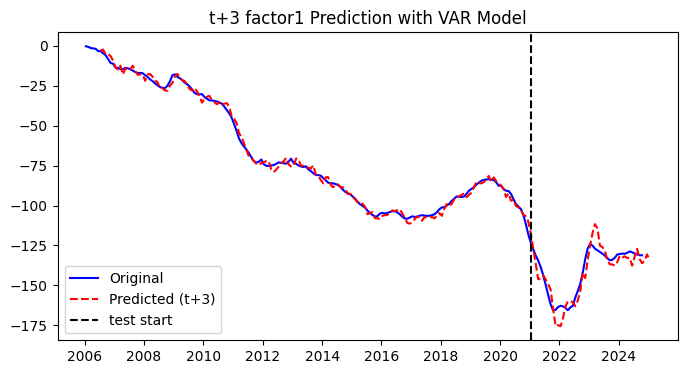

{'call_rate': 20, 'bond_3yr': 23, 'loan_rate_avg': 20, 'KOSPI': 22, 'KOSDAQ': 22, 'NASDAQ': 23, 'M2_KR': 2, 'M2_US': 18, 'broad_liquidity': 20, 'CPI_growth': 23, 'USD_KRW_rate': 22, 'GDP_growth': 23, 'res_permit': 20, 'factor1': 2}


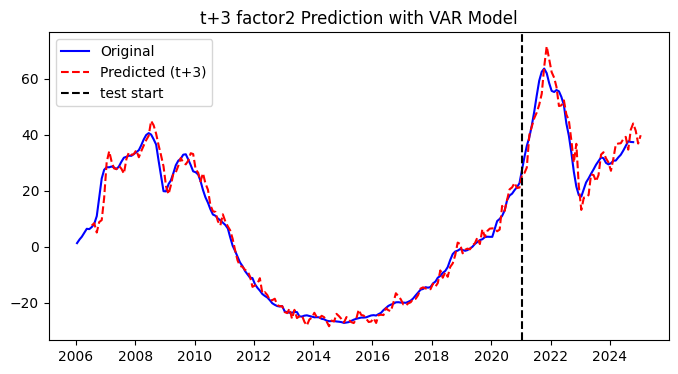

In [ ]:
forecast_dfs = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    
    forecast_dfs[factor_name] = var_forecast(df, factor_name, TEST_DATE, MAXLAG_FACTOR, SELECTED_LAG_FACTOR, FORECAST_HORIZON)
    
    plot_var_forecast(df, forecast_dfs[factor_name], factor_name, TEST_DATE, FORECAST_HORIZON)

### Kalman Filter

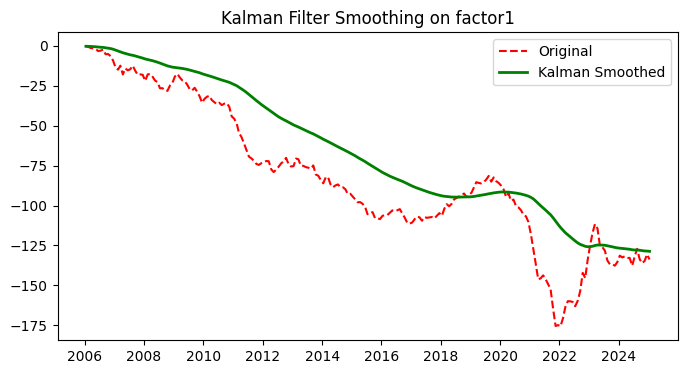

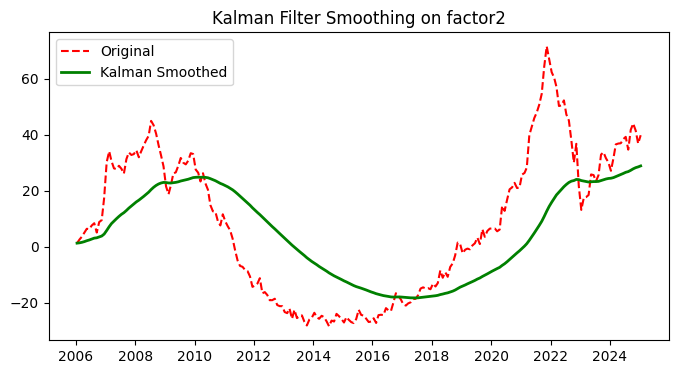

In [ ]:
smoothed_factors = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    combined_series = pd.concat([df[factor_name][TRAIN_DATE:TRAIN_DATE[:6]+str(FORECAST_HORIZON+SELECTED_LAG_FACTOR)+'-15'], forecast_dfs[factor_name][factor_name]])
    smoothed = apply_kalman_filter(combined_series, KALMAN_OBSERVATION_COV, KALMAN_TRANSITION_COV)
    plot_kalman_filter_result(combined_series, smoothed, factor_name)
    smoothed_factors[factor_name] = smoothed


### Extract Residual

In [ ]:
smoothed_factors_df = pd.concat(list(smoothed_factors.values()), axis=1)
smoothed_factors_df.columns = [f"factor{i+1}" for i in range(optimal_factors)]

common_index = target_df.index.intersection(smoothed_factors_df.index)
smoothed_factors_df = smoothed_factors_df.loc[common_index]
target_df_common = target_df.loc[common_index]

target_mean = target_df_train.mean().values
factors_adjusted = (smoothed_factors_df.values @ loadings.T) * scale_factor + target_mean + offset

resid = target_df_common - factors_adjusted
resid = resid.reset_index().rename(columns={"index": "Date"})
resid["Date"] = pd.to_datetime(resid["Date"])

### ✅ Choose Model for Residual Learning (1)
* Traditional time-series model: VAR, ARIMA

In [ ]:
new_resid = resid.set_index('Date', drop = True)

#### VAR

In [ ]:
data_diff = new_resid.diff().dropna()
train_df = data_diff[data_diff.index < TEST_DATE]
test_df = data_diff[data_diff.index >= TEST_DATE]

var_model = VAR(train_df)
var_model_fitted = var_model.fit(WINDOW_SIZE)
forecasted_levels = []  
forecast_dates = []     
for i in range(len(data_diff)- WINDOW_SIZE + 1):
    window_data = data_diff.iloc[i:i+WINDOW_SIZE].values 
    forecast_diff = var_model_fitted.forecast(window_data, steps = FORECAST_HORIZON)
    
    forecast_diff_cumsum = forecast_diff.cumsum(axis=0)[-1]  # shape: (n,)
    if i + WINDOW_SIZE < len(new_resid):
        last_level = new_resid.iloc[i + WINDOW_SIZE]
    else:
        continue
    
    pred_level = last_level + forecast_diff_cumsum
    forecasted_levels.append(pred_level)
    
    if i + WINDOW_SIZE + FORECAST_HORIZON < len(new_resid):
        forecast_date = new_resid.index[i+WINDOW_SIZE+FORECAST_HORIZON]
    else:
        last_date = pd.to_datetime(new_resid.index[-1])
        offset_periods = (i + WINDOW_SIZE + FORECAST_HORIZON) - (len(new_resid)-1)
        forecast_date = last_date + pd.DateOffset(months=offset_periods)
    forecast_dates.append(forecast_date)
forecast_df = pd.DataFrame(forecasted_levels, index=forecast_dates, columns=new_resid.columns)

for target in target_df.columns:
    real = new_resid[target][TEST_DATE:"2024-10-15"]
    pred = forecast_df[target][TEST_DATE:"2024-10-15"]
    
    rmse = round(mean_squared_error(real, pred)**0.5,3)
    mae = round(mean_absolute_error(real, pred),3)
    val =[target.split("_")[0],rmse,mae]
    # pd.DataFrame(val).T.to_csv(dir_path+f"result{version}.csv", mode='a', header=False, index=False)
    plt.figure(figsize=(10, 5))
    plt.plot(pd.to_datetime(new_resid.index), new_resid[target], label="Original", color="blue")
    plt.plot(pd.to_datetime(forecast_df.index), forecast_df[target], 
            label=f"Predicted (t+{FORECAST_HORIZON})", linestyle="dashed", color="red")
    plt.axvline(pd.to_datetime(TEST_DATE),color="black", linestyle="--", label = "test start")
    plt.legend()
    plt.title(f"t+{FORECAST_HORIZON} {target} Prediction with VAR Model")
    plt.show()

#### ARIMA

In [ ]:
for target in target_df.columns:
    x_df = new_resid
    y_df = new_resid[target]

    X_train, X_test, y_train, y_test = x_df[x_df.index<TEST_DATE], x_df[x_df.index>=TEST_DATE], y_df[y_df.index<TEST_DATE], y_df[y_df.index>=TEST_DATE]

    x_df_mu, x_df_std = X_train.mean(), X_train.std()
    y_df_mu, y_df_std = y_train.mean(), y_train.std()

    X_train = z_transform(X_train, x_df_mu, x_df_std)
    X_test = z_transform(X_test, x_df_mu, x_df_std)
    y_train = z_transform(y_train, y_df_mu, y_df_std)
    y_test = z_transform(y_test, y_df_mu, y_df_std)

    df_train_inv = pd.concat([pd.DataFrame(y_train), X_train], axis=1)
    df_test_inv = pd.concat([pd.DataFrame(y_test), X_test], axis=1)
    
    model = ARIMA(y_train, order=(1,1,1)) 
    model_fit = model.fit()

    pred_z = model_fit.forecast(steps=len(X_test))
    pred_z = np.array(pred_z)
    pred = inv_z_transform(pred_z, y_df_mu, y_df_std)
    real = inv_z_transform(y_test, y_df_mu, y_df_std)
    
    rmse = round(mean_squared_error(real, pred)**0.5,3)
    mae = round(mean_absolute_error(real, pred),3)
    val =[target.split("_")[0],rmse,mae]
    
    # pd.DataFrame(val).T.to_csv(dir_path+f"result{version}.csv", mode='a', header=False, index=False)
    plt.plot(real.values)
    plt.plot(pred)
    plt.show()

### ✅ Choose Model for Residual Learning (2)
* Deep learning: PatchLatentMLP, CARD, xPatch, LSTM, RNN, MLP

In [ ]:
from model.MLPpatchLatent import Model
from baseline.recent.CARD import Model
from baseline.recent.xPatch import Model
from baseline.traditional.LSTM import Model
from baseline.traditional.RNN import Model
from baseline.traditional.MLP import Model

### Deep Residual Learning

In [ ]:
window_size  = WINDOW_SIZE
forecast_size = FORECAST_HORIZON
idx = resid[resid['Date'] == pd.to_datetime(TEST_DATE)].index[0]
train_df = resid.iloc[:idx]
test_df  = resid.iloc[idx - (forecast_size + window_size):].reset_index(drop=True)

columns_to_use = resid.columns.drop("Date")
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, "Date", columns_to_use)
train_x, train_y, train_date_list = time_slide_df(train_df_fe, window_size, forecast_size, "Date", columns_to_use)
test_x, test_y, test_date_list   = time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)

configs = Namespace(
    seq_len      = window_size,
    pred_len     = forecast_size,
    ker_len      = 25,
    enc_in       = len(columns_to_use),
    patch_len    = 3,
    stride       = 2,
    padding_patch= 'end',
    revin        = True,
    ma_type      = 'ema',
    alpha        = 0.3,
    beta         = 0.3,
    use_patch    = True,
    patch_size   = 3,
)
train_ds = Data(train_x, train_y)
test_ds  = Data(test_x, test_y)
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=len(test_df), shuffle=False)

model = Model(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
patience   = 20
save_path  = os.path.join(DIR_PATH, f"model{VERSION}.pth")

train_loss_list, test_loss_list = train_deep_learning_model(model, train_dl, test_dl, criterion, optimizer, num_epochs, patience, save_path)
plot_loss_curve(train_loss_list, test_loss_list)



/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Draw the Results

Seoul_HPI: RMSE=7.304, MAE=6.127999782562256
Busan_HPI: RMSE=3.571, MAE=2.5889999866485596
Daegu_HPI: RMSE=3.484, MAE=2.4619998931884766
Incheon_HPI: RMSE=5.988, MAE=4.729000091552734
Gwangju_HPI: RMSE=3.627, MAE=2.700000047683716
Daejeon_HPI: RMSE=4.474, MAE=3.638000011444092
Ulsan_HPI: RMSE=2.922, MAE=2.2290000915527344
Sejong_HPI: RMSE=6.538, MAE=4.861999988555908
Gyeonggi_HPI: RMSE=6.903, MAE=5.551000118255615
Gangwon_HPI: RMSE=2.356, MAE=1.9040000438690186
Chungbuk_HPI: RMSE=2.536, MAE=2.1050000190734863
Chungnam_HPI: RMSE=2.327, MAE=1.8459999561309814
Jeonbuk_HPI: RMSE=2.736, MAE=2.259000062942505
Jeonnam_HPI: RMSE=1.661, MAE=1.24399995803833
Gyeongbuk_HPI: RMSE=2.044, MAE=1.5980000495910645
Gyeongnam_HPI: RMSE=2.03, MAE=1.5269999504089355
Jeju_HPI: RMSE=3.888, MAE=3.188999891281128


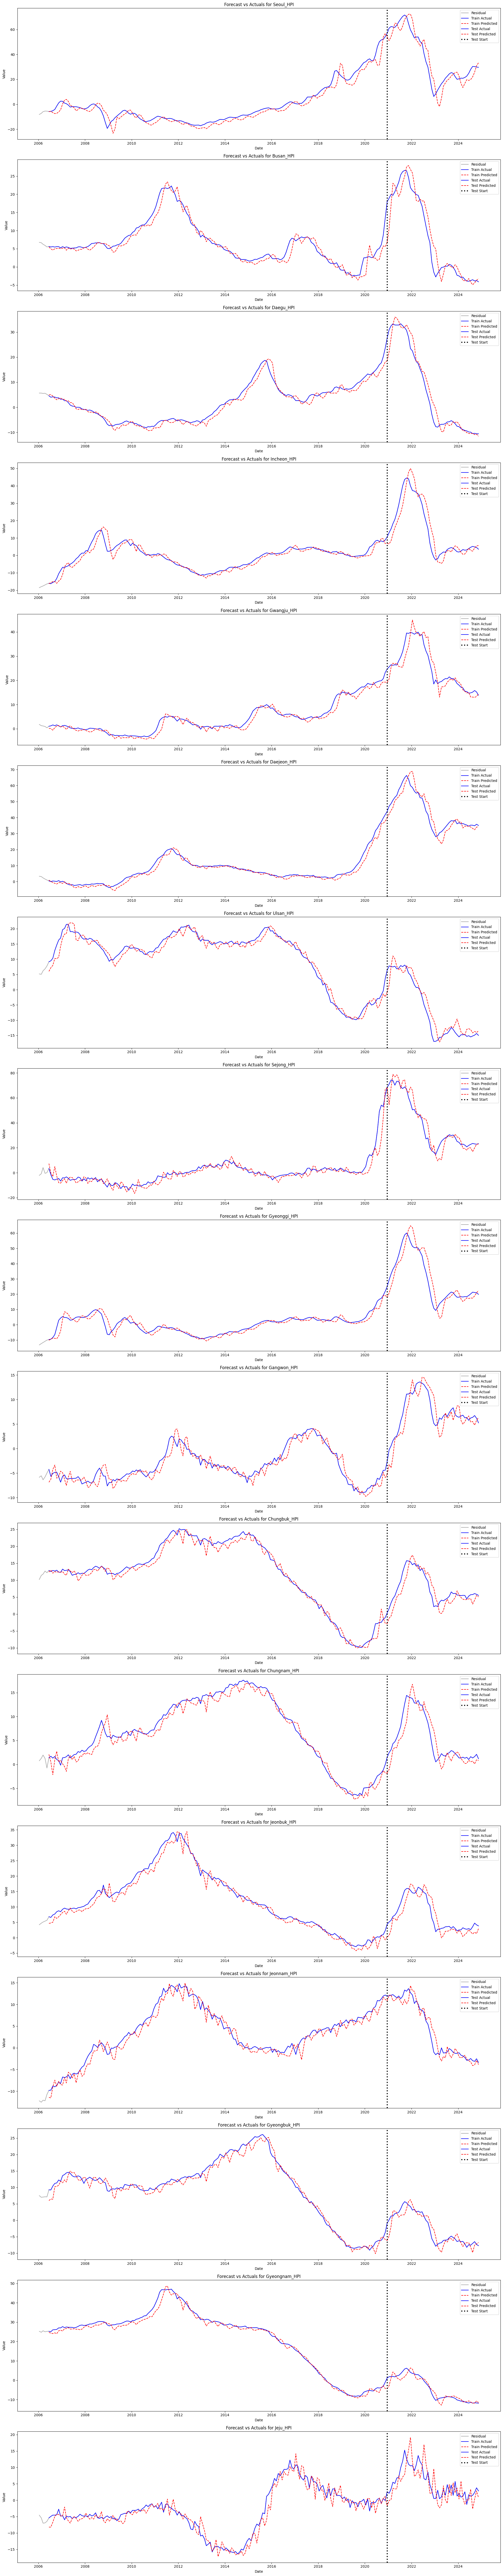

In [ ]:
model.load_state_dict(torch.load(save_path))
model.eval()

train_outputs, train_targets = evaluate_model(model, DataLoader(train_ds, batch_size=len(train_ds), shuffle=False))
test_outputs, test_targets   = evaluate_model(model, DataLoader(test_ds, batch_size=len(test_ds), shuffle=False))

train_predicted = train_outputs[:, -1, :].cpu().numpy()
train_actual    = train_targets[:, -1, :].cpu().numpy()
train_dates = train_date_list[:, -1] 

test_predicted  = test_outputs[:, -1, :].cpu().numpy()
test_actual     = test_targets[:, -1, :].cpu().numpy()
test_dates = test_date_list[:, -1] 

plot_deep_learning_results(resid, columns_to_use, train_dates, test_dates,
                           train_actual, train_predicted, test_actual, test_predicted,
                           mean_, std_)


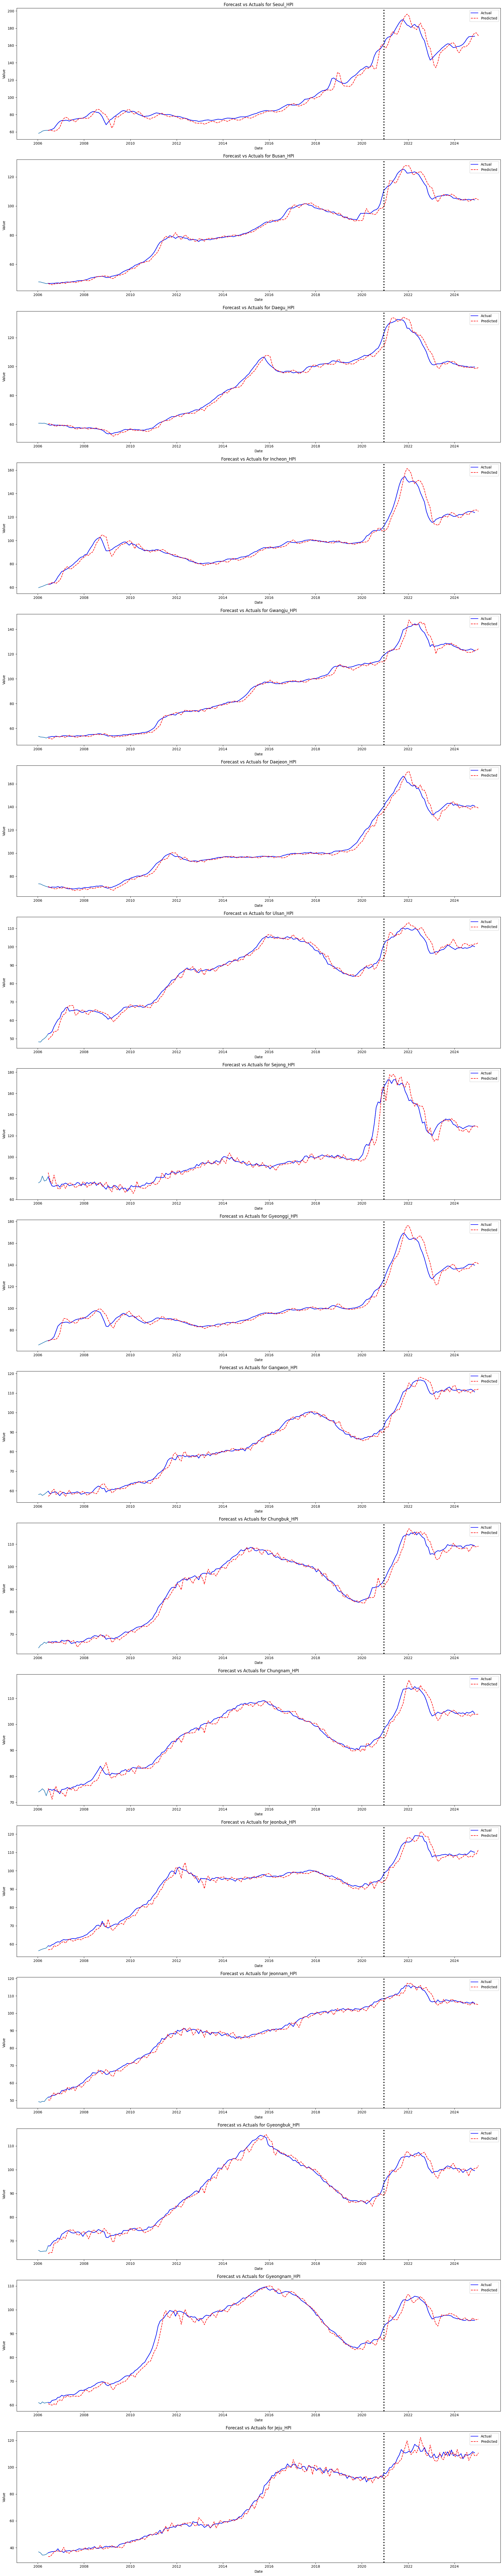

In [ ]:
additional_test_x, additional_test_y, additional_test_date = test_time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)
addi_test_ds = Data(additional_test_x, additional_test_y)
addi_test_dl  = DataLoader(addi_test_ds, batch_size=len(additional_test_x), shuffle=False)
with torch.no_grad():
    for data, target in addi_test_dl:
        addi_test_output = model(data)
        addi_test_predicted = addi_test_output[:, -1, :].cpu().numpy() 

f = (pd.concat(smoothed_factors,axis=1).values @ loadings.T) * scale_factor + target_df_train.mean().values + offset
f_pd_all = pd.DataFrame(f, index=pd.to_datetime(smoothed_factors['factor1'].index), columns=target_df.columns)

plot_additional_test_predictions(target_df, columns_to_use,
                                 train_actual, train_predicted,
                                 test_actual, test_predicted,
                                 addi_test_predicted,
                                 train_dates, test_dates,
                                 mean_, std_, f_pd_all, forecast_size)